In [1]:
import vector, time
import awkward as ak
from coffea import processor
from coffea.nanoevents.methods import candidate
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import json
import hist
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.ROOT, hep.style.firamath])
import pickle, glob
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from hist import hist

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-z8f3v4bc because the default path (/uscms/home/bbbam/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Counts total events 
### Counts events with exactly reco taus and more than 1 reco taus (2 or more)
### Counts events with exactly reco taus and more than 2 reco taus (2 or more) passing trigger
### Plots histogram for invarient mass spectrun from two reco taus (taking two leading pt taus if more than 2) with and without applying trigger determined by flag `trigg_applied_invariant_mass`

In [7]:

class TauRecoGenMatchCounter_trig(processor.ProcessorABC):

    def __init__(
        self,
        max_events=10000,
        dr_max=0.4,
        h_mass_bins=np.arange(20, 150, 5),
        trig_applied_invariant_mass = False,
    ):
        self.max_events = max_events
        self.dr_max = dr_max
        self.trig_applied_invariant_mass = trig_applied_invariant_mass
        self._processed = 0

        # -----------------------------
        # Accumulator
        # -----------------------------
        self._accumulator = {

            # Mass histograms (NO trigger)
            "h_mass_exactly2": hist.Hist.new.Reg(
                len(h_mass_bins) - 1,
                h_mass_bins[0],
                h_mass_bins[-1],
                name="m",
                label="Visible di-τ mass [GeV]",
            ).Double(),

            "h_mass_morethan1": hist.Hist.new.Reg(
                len(h_mass_bins) - 1,
                h_mass_bins[0],
                h_mass_bins[-1],
                name="m",
                label="Visible di-τ mass [GeV]",
            ).Double(),

            # Event counters
            "n_events": 0,

            "n_exactly2": 0,
            "n_morethan1": 0,

            "n_exactly2_trig": 0,
            "n_morethan1_trig": 0,
        }

    @property
    def accumulator(self):
        return self._accumulator

    # ============================================================
    # PROCESS
    # ============================================================
    def process(self, events):

        # ---------------------------------
        # Limit total processed events
        # ---------------------------------
        if self._processed >= self.max_events:
            return self.accumulator

        remaining = self.max_events - self._processed
        events = events[:remaining]
        self._processed += len(events)

        self._accumulator["n_events"] += len(events)

        # ============================================================
        # TRIGGER: OR of all DoubleMediumDeepTau paths
        # ============================================================
        hlt = events.HLT

        trigger_names = [
            name for name in hlt.fields
            if "DoubleMediumDeepTau" in name
        ]

        if len(trigger_names) == 0:
            trig_mask = ak.zeros_like(events.event, dtype=bool)
        else:
            # OR over all DoubleMediumDeepTau trigger paths
            trig_mask = ak.any(
                [hlt[name] for name in trigger_names],
                axis=0
            )

        # ============================================================
        # RECO & GEN
        # ============================================================
        reco_tau = events.Tau
        gen = events.GenPart
        gen_tau = gen[abs(gen.pdgId) == 15]

        # ============================================================
        # RECO–GEN MATCHING (ΔR)
        # ============================================================
        pairs = ak.cartesian(
            {"reco": reco_tau, "gen": gen_tau},
            axis=1,
            nested=True,
        )

        dphi = np.abs(pairs.reco.phi - pairs.gen.phi)
        dphi = ak.where(dphi > np.pi, 2 * np.pi - dphi, dphi)
        deta = pairs.reco.eta - pairs.gen.eta
        dr = np.sqrt(deta**2 + dphi**2)

        matched = dr < self.dr_max
        reco_is_matched = ak.any(matched, axis=2)
        n_matched_reco = ak.sum(reco_is_matched, axis=1)

        # ============================================================
        # EVENT MASKS (NO trigger)
        # ============================================================
        mask_exactly2 = n_matched_reco == 2
        mask_morethan1 = n_matched_reco > 1

        # Triggered versions (OR trigger)
        mask_exactly2_trig = mask_exactly2 & trig_mask
        mask_morethan1_trig = mask_morethan1 & trig_mask

        # ============================================================
        # COUNTERS
        # ============================================================
        self._accumulator["n_exactly2"] += int(ak.sum(mask_exactly2))
        self._accumulator["n_morethan1"] += int(ak.sum(mask_morethan1))

        self._accumulator["n_exactly2_trig"] += int(ak.sum(mask_exactly2_trig))
        self._accumulator["n_morethan1_trig"] += int(ak.sum(mask_morethan1_trig))

        # ============================================================
        # HISTOGRAMS 
        # ============================================================

        # ---------- EXACTLY 2 matched reco taus ----------
        if self.trig_applied_invariant_mass:
            mask = mask_exactly2_trig
        else:
            mask = mask_exactly2
            
        tau_exact2 = reco_tau[mask]
        match_exact2 = reco_is_matched[mask]
        tau_exact2 = tau_exact2[match_exact2]
        

            
       

        if len(tau_exact2) > 0:
            tau1, tau2 = tau_exact2[:, 0], tau_exact2[:, 1]

            vec1 = vector.array({
                "pt": tau1.pt,
                "eta": tau1.eta,
                "phi": tau1.phi,
                "mass": tau1.mass,
            })
            vec2 = vector.array({
                "pt": tau2.pt,
                "eta": tau2.eta,
                "phi": tau2.phi,
                "mass": tau2.mass,
            })

            h_mass = (vec1 + vec2).mass
            self._accumulator["h_mass_exactly2"].fill(m=h_mass)

        # ---------- MORE THAN 1 matched reco tau ----------
        if self.trig_applied_invariant_mass:
            mask = mask_morethan1_trig
        else:
            mask = mask_morethan1
            
        tau_more = reco_tau[mask]
        match_more = reco_is_matched[mask]
        tau_more = tau_more[match_more]
            
        
            

        if len(tau_more) > 0:
            order = ak.argsort(tau_more.pt, axis=1, ascending=False)
            tau_top2 = tau_more[order][:, :2]

            tau1, tau2 = tau_top2[:, 0], tau_top2[:, 1]

            vec1 = vector.array({
                "pt": tau1.pt,
                "eta": tau1.eta,
                "phi": tau1.phi,
                "mass": tau1.mass,
            })
            vec2 = vector.array({
                "pt": tau2.pt,
                "eta": tau2.eta,
                "phi": tau2.phi,
                "mass": tau2.mass,
            })

            h_mass = (vec1 + vec2).mass
            self._accumulator["h_mass_morethan1"].fill(m=h_mass)

        return self.accumulator

    # ============================================================
    # POSTPROCESS
    # ============================================================
    def postprocess(self, acc):

        acc["eff_exactly2"] = (
            acc["n_exactly2_trig"] / acc["n_exactly2"]
            if acc["n_exactly2"] > 0 else 0.0
        )

        acc["eff_morethan1"] = (
            acc["n_morethan1_trig"] / acc["n_morethan1"]
            if acc["n_morethan1"] > 0 else 0.0
        )

        return acc


### The script in below can be used for large scale input files. For now keep these commented

In [8]:
# # with open("HTo2Tau_hadronic.json", "r") as fin:
# #     file_list_1 = json.load(fin) 
# with open("HToAATo4Tau_M3p7.json", "r") as fin:
#     file_list_3p7 = json.load(fin) 

# fileset = {
#     # 'HTo2Tau_files': file_list_1 
#     'HToAATo4Tau_M3p7_files': file_list_3p7,
                  
# }

# futures_run = processor.Runner(
#     executor = processor.FuturesExecutor(compression=None, workers=1),
#     schema=NanoAODSchema,
#     # maxchunks=1,
# )

# out = futures_run(
#     fileset,
#     treename='Events',
#     processor_instance=TauRecoGenMatchCounter_trig()
# )
# with open(f'{out_dir}/HTo2Tau_event_counts.pkl', 'wb') as f:
#     pickle.dump(out, f)

### Specifying input and out file files paths. Run the script out put will saved to coressponding pkl files

In [9]:
in_filenames = ["HTo2Tau_hadronic.root", "NanoAOD_HToAATo4Tau_M3p7.root", "NanoAOD_HToAATo4Tau_M6.root", "NanoAOD_HToAATo4Tau_M8.root", "NanoAOD_HToAATo4Tau_M10.root"]
out_filenames = ["HTo2Tau_hadronic.pkl", "NanoAOD_HToAATo4Tau_M3p7.pkl", "NanoAOD_HToAATo4Tau_M6.pkl", "NanoAOD_HToAATo4Tau_M8.pkl", "NanoAOD_HToAATo4Tau_M10.pkl"]
out_filenames_trig = ["HTo2Tau_hadronic_trig.pkl", "NanoAOD_HToAATo4Tau_M3p7_trig.pkl", "NanoAOD_HToAATo4Tau_M6_trig.pkl", "NanoAOD_HToAATo4Tau_M8_trig.pkl", "NanoAOD_HToAATo4Tau_M10_trig.pkl"]
in_dir = "root://cmseos.fnal.gov//store/group/lpcml/bbbam/10K_events_feasibility_test"
out_dir = "output_pkl"
for i, filename in enumerate(in_filenames):
    file = uproot.open(f"{in_dir}/{filename}")
    events = NanoEventsFactory.from_root(
        file,
        treepath='Events',
        entry_start=None,
        # entry_stop=1,
        # metadata={"train_dataset_1": "jet"},
        schemaclass=NanoAODSchema,
    ).events()
    p = TauRecoGenMatchCounter_trig()
    out = p.process(events)
    with open(f'{out_dir}/{out_filenames[i]}', 'wb') as f:
        pickle.dump(out, f)
    print(out)

{'h_mass_exactly2': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 5285.0 (5292.0 with flow), 'h_mass_morethan1': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 5290.0 (5297.0 with flow), 'n_events': 10000, 'n_exactly2': 5292, 'n_morethan1': 5297, 'n_exactly2_trig': 607, 'n_morethan1_trig': 608}
{'h_mass_exactly2': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 4207.0, 'h_mass_morethan1': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 4207.0, 'n_events': 10000, 'n_exactly2': 4207, 'n_morethan1': 4207, 'n_exactly2_trig': 105, 'n_morethan1_trig': 105}
{'h_mass_exactly2': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 3412.0 (3415.0 with flow), 'h_mass_morethan1': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # 

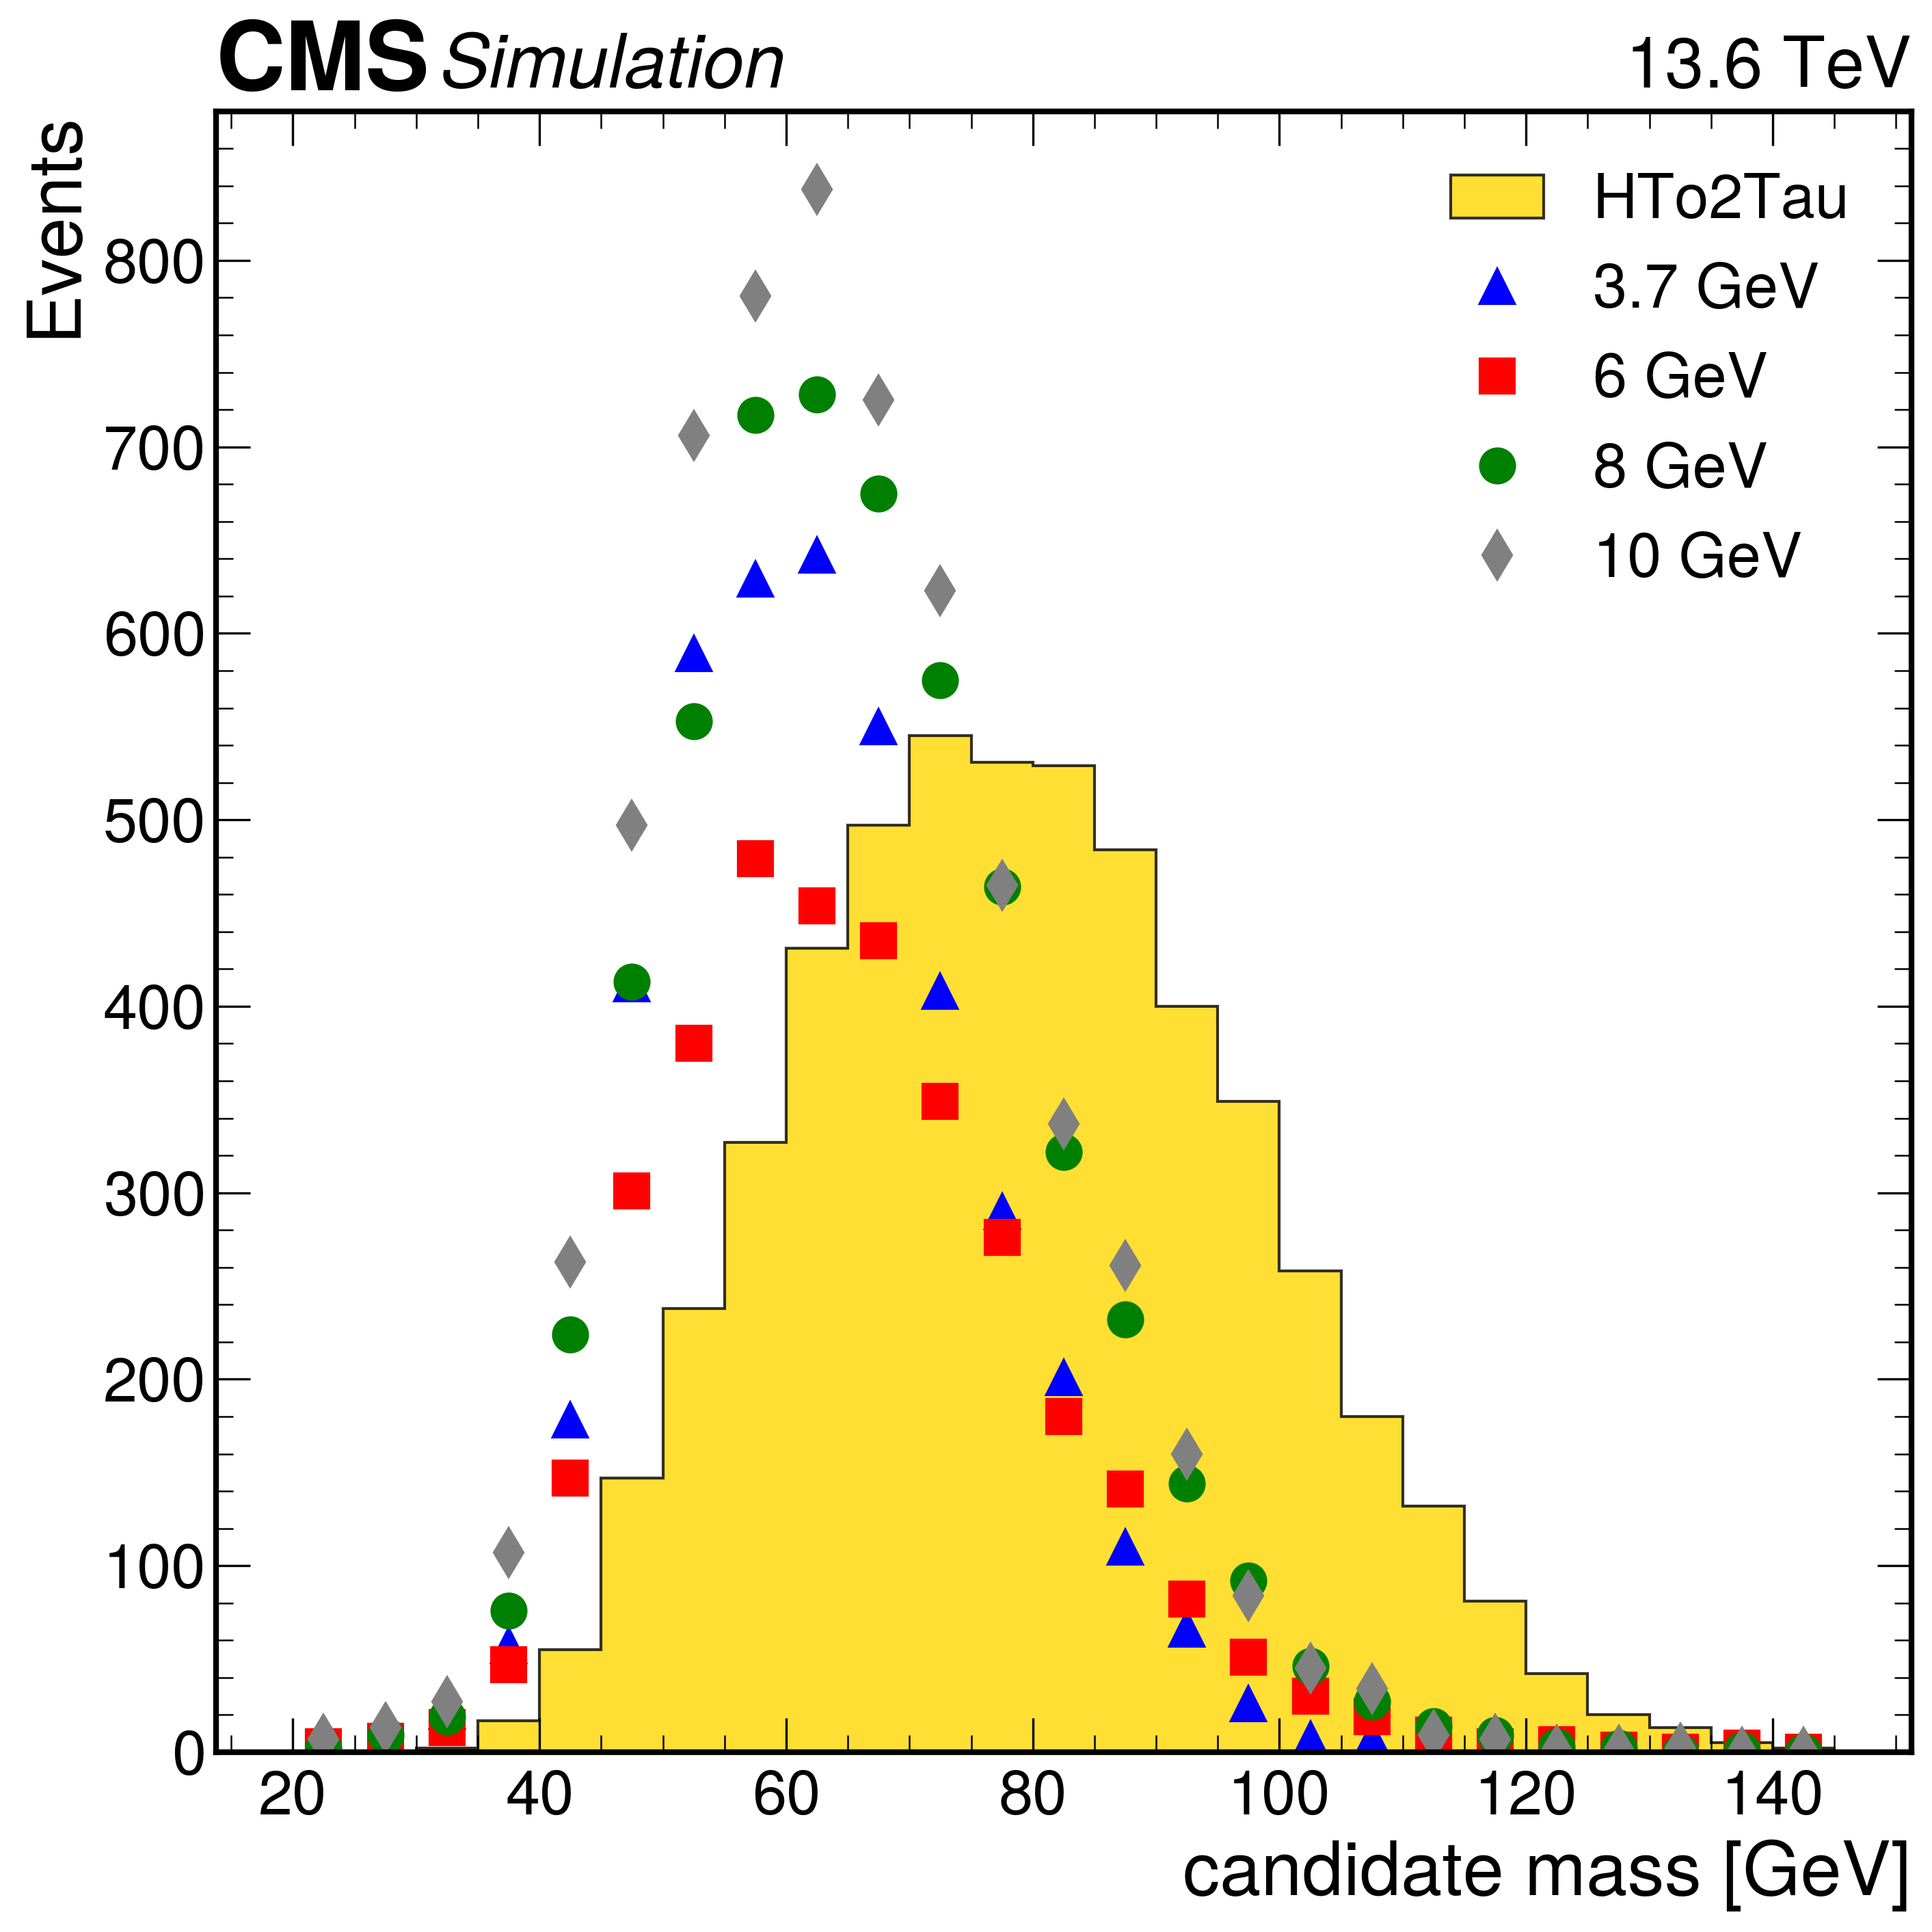

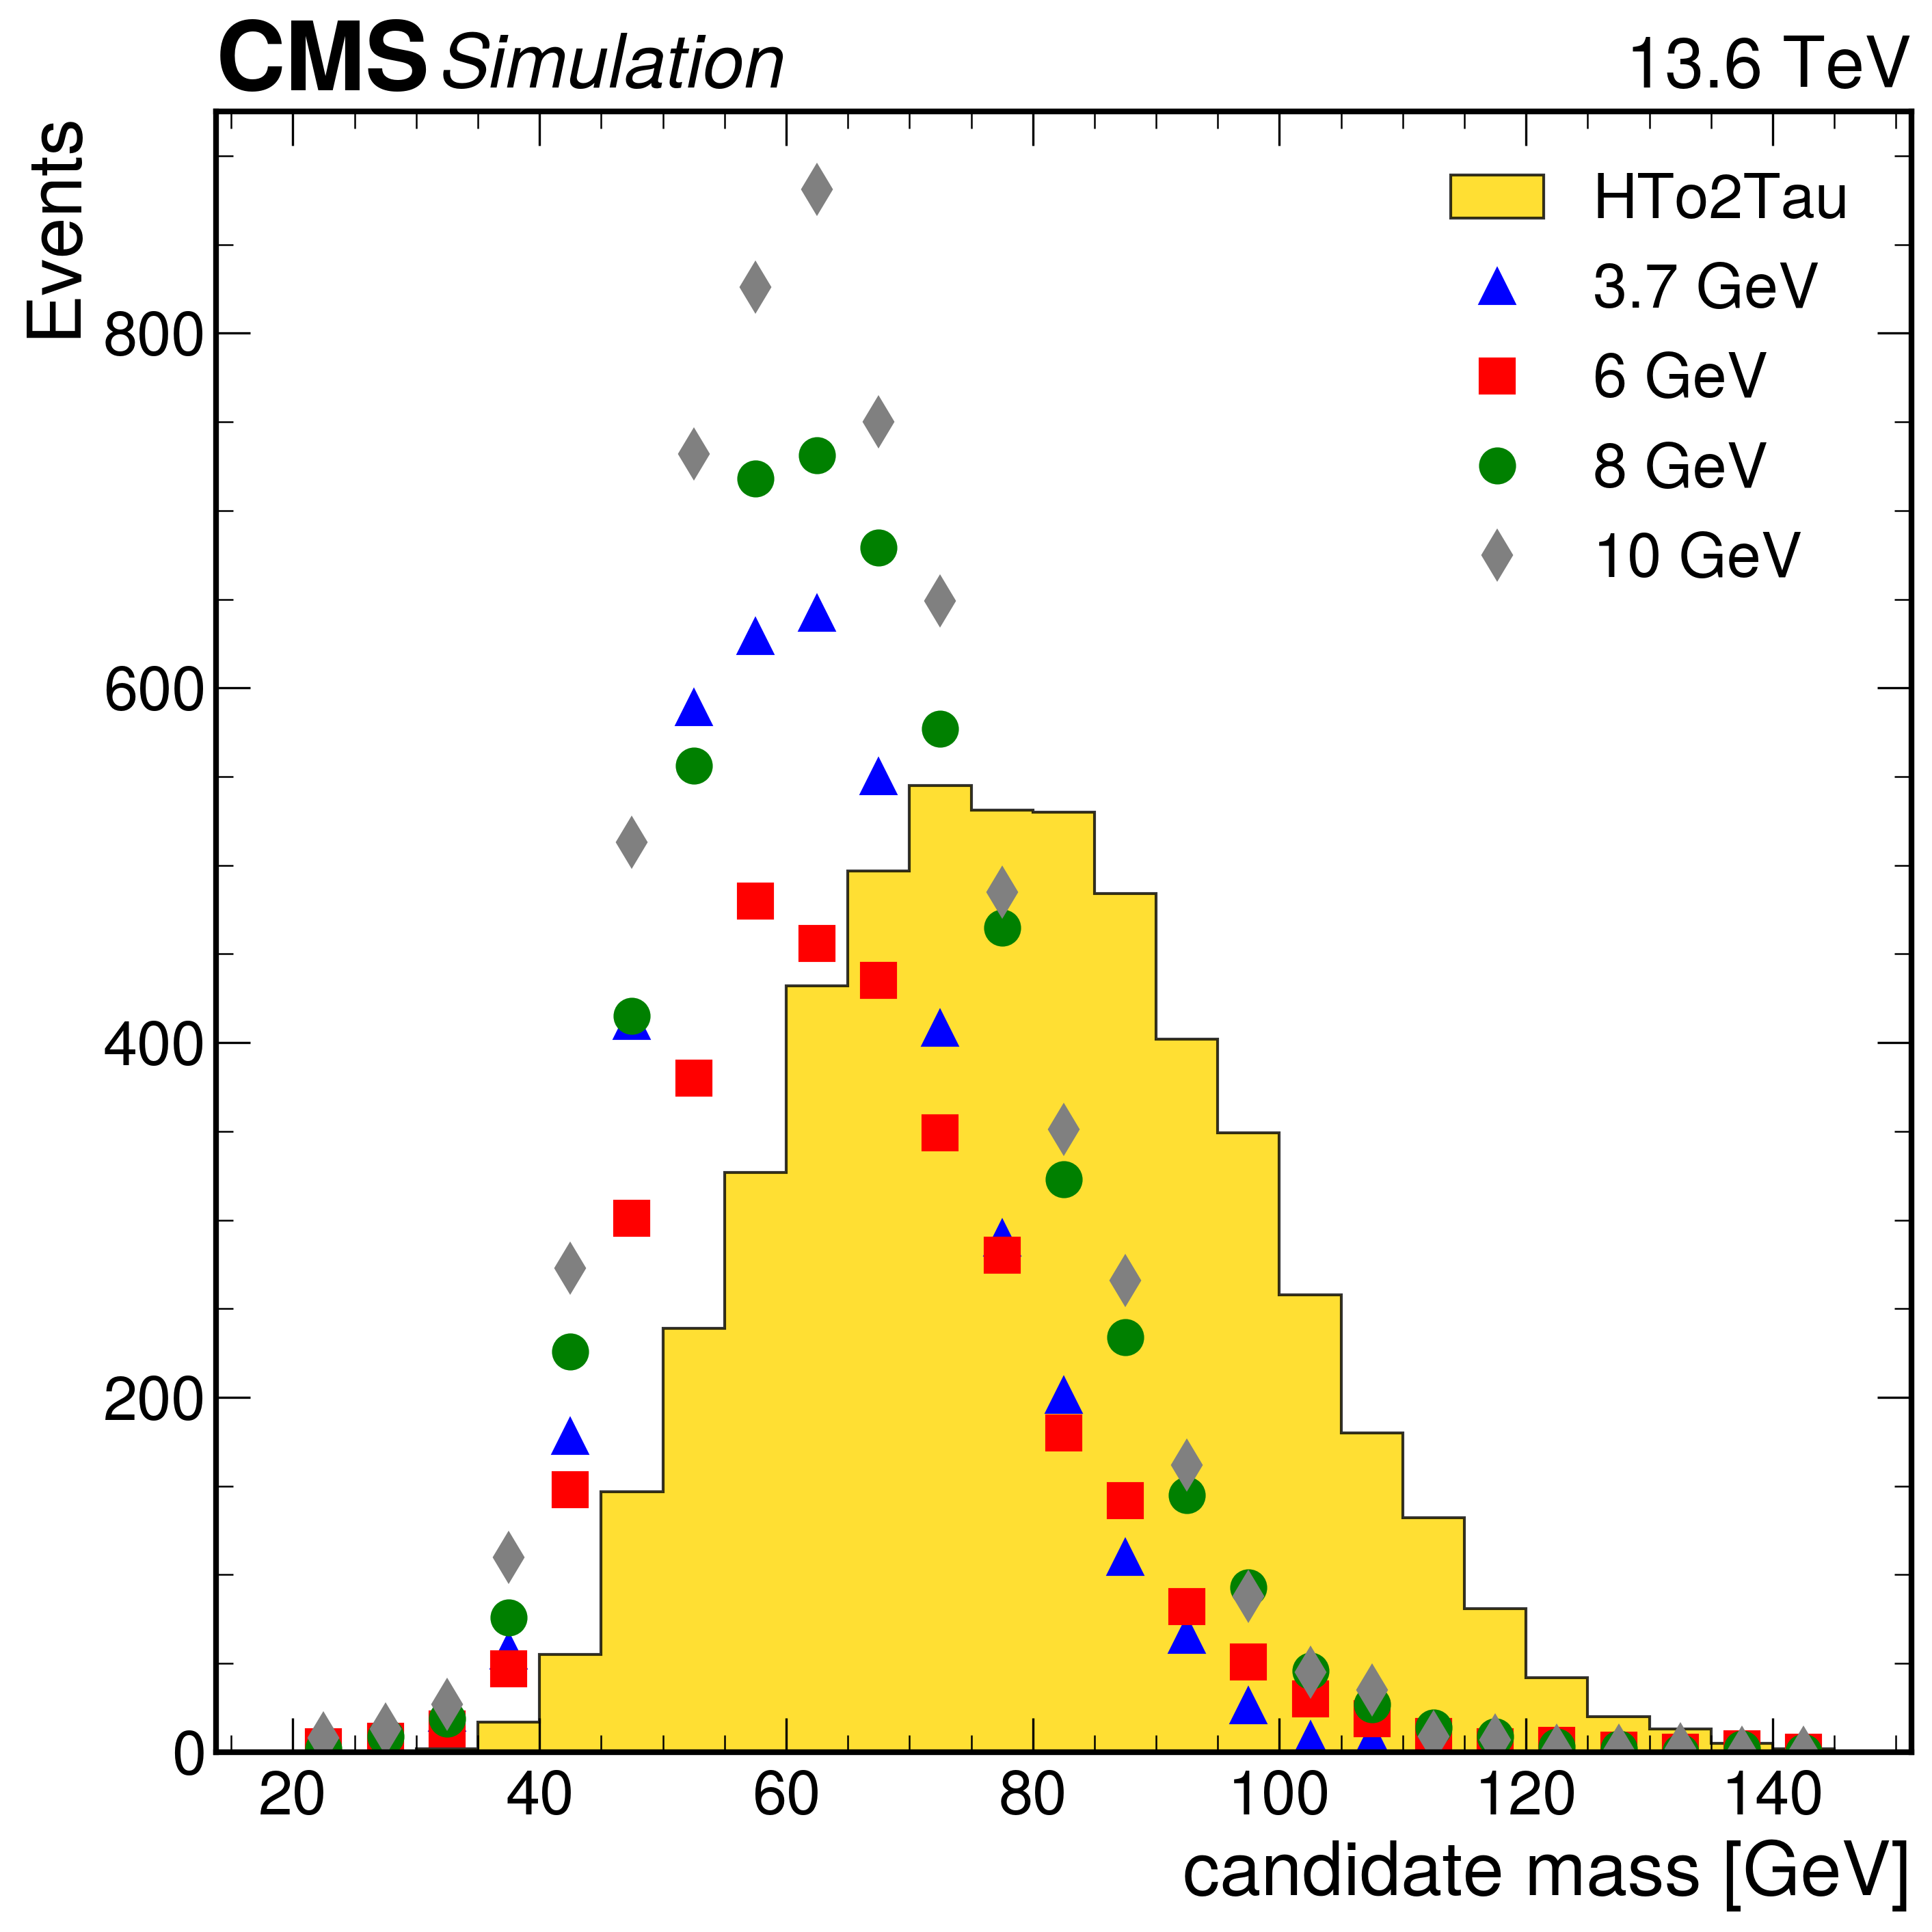

In [11]:
with open(f'{out_dir}/HTo2Tau_hadronic.pkl', 'rb') as f:
    hto2tau = pickle.load(f)
    
with open(f'{out_dir}/NanoAOD_HToAATo4Tau_M3p7.pkl', 'rb') as f:
    m3p7 = pickle.load(f)
    
with open(f'{out_dir}/NanoAOD_HToAATo4Tau_M6.pkl', 'rb') as f:
    m6 = pickle.load(f)

with open(f'{out_dir}/NanoAOD_HToAATo4Tau_M8.pkl', 'rb') as f:
    m8 = pickle.load(f)
    
with open(f'{out_dir}/NanoAOD_HToAATo4Tau_M10.pkl', 'rb') as f:
    m10 = pickle.load(f)

# Get histograms from accumulator
h_mass_2taus_hto2tau = hto2tau['h_mass_exactly2']
h_mass_more2_hto2tau = hto2tau['h_mass_morethan1']

h_mass_2taus_m3p7 = m3p7['h_mass_exactly2']
h_mass_more2_m3p7 = m3p7['h_mass_morethan1']

h_mass_2taus_m6 = m6['h_mass_exactly2']
h_mass_more2_m6 = m6['h_mass_morethan1']

h_mass_2taus_m8 = m8['h_mass_exactly2']
h_mass_more2_m8 = m8['h_mass_morethan1']

h_mass_2taus_m10 = m10['h_mass_exactly2']
h_mass_more2_m10 = m10['h_mass_morethan1']

# Extract bin edges and counts
bins_hto2tau = h_mass_2taus_hto2tau.axes[0].edges
bin_centers_hto2tau = 0.5 * (bins_hto2tau[1:] + bins_hto2tau[:-1])
counts_2_hto2tau = h_mass_2taus_hto2tau.values()
counts_more2_hto2tau = h_mass_more2_hto2tau.values()

bins_m3p7 = h_mass_2taus_m3p7.axes[0].edges
bin_centers_m3p7 = 0.5 * (bins_m3p7[1:] + bins_m3p7[:-1])
counts_2_m3p7 = h_mass_2taus_m3p7.values()
counts_more2_m3p7 = h_mass_more2_m3p7.values()
errors_2_m3p7 = np.sqrt(counts_2_m3p7)
errors_more2_m3p7 = np.sqrt(counts_more2_m3p7)


bins_m6 = h_mass_2taus_m6.axes[0].edges
bin_centers_m6 = 0.5 * (bins_m6[1:] + bins_m6[:-1])
counts_2_m6 = h_mass_2taus_m6.values()
counts_more2_m6 = h_mass_more2_m6.values()
errors_2_m6 = np.sqrt(counts_2_m6)
errors_more2_m6 = np.sqrt(counts_more2_m6)

bins_m8 = h_mass_2taus_m8.axes[0].edges
bin_centers_m8 = 0.5 * (bins_m8[1:] + bins_m8[:-1])
counts_2_m8 = h_mass_2taus_m8.values()
counts_more2_m8 = h_mass_more2_m8.values()
errors_2_m8 = np.sqrt(counts_2_m8)
errors_more2_m8 = np.sqrt(counts_more2_m8)

bins_m10 = h_mass_2taus_m10.axes[0].edges
bin_centers_m10 = 0.5 * (bins_m10[1:] + bins_m10[:-1])
counts_2_m10 = h_mass_2taus_m10.values()
counts_more2_m10 = h_mass_more2_m10.values()
errors_2_m10 = np.sqrt(counts_2_m10)
errors_more2_m10 = np.sqrt(counts_more2_m10)


# -------------------------
# Plot
# -------------------------

fig, ax = plt.subplots(dpi=300)

# Filled histogram (like yellow Higgs shape)
plt.hist(
    bins_hto2tau[:-1],
    bins=bins_hto2tau,
    weights=counts_2_hto2tau,
    histtype="stepfilled",
    color="gold",
    edgecolor="black",
    alpha=0.8,
    label="HTo2Tau"
)

# Overlay second hist as points with errors
plt.errorbar(
    bin_centers_m3p7,
    counts_2_m3p7,
    # yerr=errors_2_m3p7,
    fmt='^',
    markersize=12,
    color='blue',
    label="3.7 GeV",
    capsize=2
)
plt.errorbar(
    bin_centers_m6,
    counts_2_m6,
    # yerr=errors_2_m6,
    fmt='s',
    markersize=12,
    color='red',
    label="6 GeV",
    capsize=2
)

plt.errorbar(
    bin_centers_m8,
    counts_2_m8,
    # yerr=errors_2_m8,
    fmt='o',
    markersize=12,
    color='green',
    label="8 GeV",
    capsize=2
)

plt.errorbar(
    bin_centers_m10,
    counts_2_m10,
    # yerr=errors_2_m10,
    fmt='d',
    markersize=12,
    color='grey',
    label="10 GeV",
    capsize=5
)

# Labels & styling
plt.xlabel("candidate mass [GeV]")
plt.ylabel("Events")
# plt.title("candidate_mass")
plt.legend()
hep.cms.label(llabel="Simulation", rlabel="13.6 TeV", loc=0, ax=ax)
plt.tight_layout()
# plt.savefig(f'plot/candidate_invarient_mass_from_excatelty_2_reco_tau_pass_trig.pdf',facecolor='w',dpi=300)



fig, ax = plt.subplots(dpi=300)

# Filled histogram (like yellow Higgs shape)
plt.hist(
    bins_hto2tau[:-1],
    bins=bins_hto2tau,
    weights=counts_more2_hto2tau,
    histtype="stepfilled",
    color="gold",
    edgecolor="black",
    alpha=0.8,
    label="HTo2Tau"
)

# Overlay second hist as points with errors
plt.errorbar(
    bin_centers_m3p7,
    counts_more2_m3p7,
    # yerr=errors_more2_m3p7,
    fmt='^',
    markersize=12,
    color='blue',
    label="3.7 GeV",
    capsize=2
)
plt.errorbar(
    bin_centers_m6,
    counts_more2_m6,
    # yerr=errors_more2_m6,
    fmt='s',
    markersize=12,
    color='red',
    label="6 GeV",
    capsize=2
)

plt.errorbar(
    bin_centers_m8,
    counts_more2_m8,
    # yerr=errors_more2_m8,
    fmt='o',
    markersize=12,
    color='green',
    label="8 GeV",
    capsize=2
)

plt.errorbar(
    bin_centers_m10,
    counts_more2_m10,
    # yerr=errors_2_m10,
    fmt='d',
    markersize=12,
    color='grey',
    label="10 GeV",
    capsize=5
)

# Labels & styling
plt.xlabel("candidate mass [GeV]")
plt.ylabel("Events")
# plt.title("candidate_mass")
plt.legend()
hep.cms.label(llabel="Simulation", rlabel="13.6 TeV", loc=0, ax=ax)
plt.tight_layout()
# plt.savefig(f'plot/candidate_invarient_mass_from_2_or_more_reco_tau_pass_trig.pdf',facecolor='w',dpi=300)


In [ ]:
# from pprint import pprint
# for i, out_file in enumerate(out_filenames):
#     print("dataset  ",in_filenames[i]) 
#     with open(f'{out_file}', 'rb') as f:
#         out = pickle.load(f)
#     pprint({k: v for k, v in out.items() if not hasattr(v, "axes")})

### Simply counts Number of events passed the trigger and plot histogram with invarient mass from reco tau (select 2 leading pt tau)

In [12]:

class TriggerCounter(processor.ProcessorABC):

    def __init__(
        self,
        max_events=10000,
        h_mass_bins=np.arange(20, 150, 5),
    ):
        self.max_events = max_events
        self._processed = 0

        # ============================================================
        # Accumulator
        # ============================================================
        self._accumulator = {

            # -----------------------------
            # Visible di-tau mass histogram
            # -----------------------------
            "h_mass": hist.Hist.new.Reg(
                len(h_mass_bins) - 1,
                h_mass_bins[0],
                h_mass_bins[-1],
                name="m",
                label="Visible di-τ mass [GeV]",
            ).Double(),

            # -----------------------------
            # Event counters
            # -----------------------------
            "n_events": 0,
            "n_trig": 0,
        }

    @property
    def accumulator(self):
        return self._accumulator

    # ============================================================
    # PROCESS
    # ============================================================
    def process(self, events):

        # ---------------------------------
        # Limit total processed events
        # ---------------------------------
        if self._processed >= self.max_events:
            return self.accumulator

        remaining = self.max_events - self._processed
        events = events[:remaining]
        self._processed += len(events)

        # Count total events
        self._accumulator["n_events"] += len(events)

        # ============================================================
        # TRIGGER: OR of all DoubleMediumDeepTau paths
        # ============================================================
        hlt = events.HLT

        trigger_names = [
            name for name in hlt.fields
            if "DoubleMediumDeepTau" in name
        ]

        if len(trigger_names) == 0:
            trig_mask = ak.zeros_like(events.event, dtype=bool)
        else:
            trig_mask = ak.any(
                [hlt[name] for name in trigger_names],
                axis=0
            )

        # Count triggered events
        self._accumulator["n_trig"] += int(ak.sum(trig_mask))

        # ============================================================
        # RECO TAUS (triggered events only)
        # ============================================================
        reco_tau = events.Tau
        tau = reco_tau[trig_mask]

        # Require at least 2 taus per event
        mask_atleast2 = ak.num(tau) >= 2
        tau = tau[mask_atleast2]

        # If nothing survives, exit early
        if len(tau) == 0:
            return self.accumulator

        # ============================================================
        # Pick two leading-pT taus per event
        # ============================================================
        order = ak.argsort(tau.pt, axis=1, ascending=False)
        tau_top2 = tau[order][:, :2]

        tau1 = tau_top2[:, 0]
        tau2 = tau_top2[:, 1]

        # ============================================================
        # Build Lorentz vectors
        # ============================================================
        vec1 = vector.array({
            "pt": tau1.pt,
            "eta": tau1.eta,
            "phi": tau1.phi,
            "mass": tau1.mass,
        })

        vec2 = vector.array({
            "pt": tau2.pt,
            "eta": tau2.eta,
            "phi": tau2.phi,
            "mass": tau2.mass,
        })

        # Visible di-tau mass
        h_mass = (vec1 + vec2).mass

        # ============================================================
        # Fill histogram (robust flattening)
        # ============================================================
        self._accumulator["h_mass"].fill(
            m=ak.flatten(h_mass, axis=None)
        )

        return self.accumulator

    # ============================================================
    # POSTPROCESS
    # ============================================================
    def postprocess(self, acc):
        return acc


### Give input and outpu file path. run following line and out put will saved as pkl file

In [14]:
in_filenames = ["HTo2Tau_hadronic.root", "NanoAOD_HToAATo4Tau_M3p7.root", "NanoAOD_HToAATo4Tau_M6.root", "NanoAOD_HToAATo4Tau_M8.root", "NanoAOD_HToAATo4Tau_M10.root"]
out_filenames = ["HTo2Tau_hadronic_only_trig.pkl", "NanoAOD_HToAATo4Tau_M3p7_only_trig.pkl", "NanoAOD_HToAATo4Tau_M6_only_trig.pkl", "NanoAOD_HToAATo4Tau_M8_only_trig.pkl", "NanoAOD_HToAATo4Tau_M10_only_trig.pkl"]
in_dir = "root://cmseos.fnal.gov//store/group/lpcml/bbbam/10K_events_feasibility_test"
out_dir = "output_pkl"

for i, filename in enumerate(in_filenames):
    file = uproot.open(f'{in_dir}/{filename}')
    events = NanoEventsFactory.from_root(
        file,
        treepath='Events',
        entry_start=None,
        # entry_stop=1,
        # metadata={"train_dataset_1": "jet"},
        schemaclass=NanoAODSchema,
    ).events()
    p = TriggerCounter()
    out = p.process(events)
    with open(f'{out_dir}/{out_filenames[i]}', 'wb') as f:
        pickle.dump(out, f)
    print(out)

{'h_mass': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 607.0 (618.0 with flow), 'n_events': 10000, 'n_trig': 626}
{'h_mass': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 109.0 (117.0 with flow), 'n_events': 10000, 'n_trig': 139}
{'h_mass': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 85.0 (95.0 with flow), 'n_events': 10000, 'n_trig': 120}
{'h_mass': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 120.0 (126.0 with flow), 'n_events': 10000, 'n_trig': 143}
{'h_mass': Hist(Regular(25, 20, 145, name='m', label='Visible di-τ mass [GeV]'), storage=Double()) # Sum: 152.0 (164.0 with flow), 'n_events': 10000, 'n_trig': 178}
